### Network analysis with a StackOverflow Tags (programming languages) dataset

- From Kaggle
- Typically done as a from of EDA
- This is a simple way to find out typically which programming languages and tools are clustered together

In [233]:
# Package imports
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import networkx as nx

pd.set_option("display.max_columns", None)
plt.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

warnings.simplefilter('ignore')

In [179]:
# Import data from tabular csv files
edges = pd.read_csv("/Users/marzimin/Downloads/archive/stack_network_links.csv")
nodes = pd.read_csv("/Users/marzimin/Downloads/archive/stack_network_nodes.csv")

#### Context

On the data team at Stack Overflow, we spend a lot of time and energy thinking about tech ecosystems and how technologies are related to each other. One way to get at this idea of relationships between technologies is tag correlations, how often technology tags at Stack Overflow appear together relative to how often they appear separately. One place we see developers using tags at Stack Overflow is on their Developer Stories, or professional profiles/CVs/resumes. If we are interested in how technologies are connected and how they are used together, developers' own descriptions of their work and careers is a great place to get that.

#### Content

A network of technology tags from Developer Stories on the Stack Overflow online developer community website.

This is organized as two tables:

- `stacknetworklinks` (edges) contains links of the network, the source and target tech tags plus the value of the the link between each pair
- `stacknetworknodes` (nodes) contains nodes of the network, the name of each node, which group that node belongs to (precalculated via a cluster walktrap), and a node size based on how often that technology tag is used on the website

This dataset does include only a subset of tags used on Developer Stories, tags that were used by at least 0.5% of users and were correlated with another tag with a correlation coefficient above 0.1. This means that very sparsely used tags and tags that are not used with other tags were filtered out.

The numerical values for nodesize and value have been scaled for the D3 visualization on the Kaggle page. The quantity nodesize is proportional to how many developers have that tag on their Developer Story, and the quantity value is proportional to how correlated those two tags are (correlation coefficient * 100).

In [180]:
# check .head() and check for nulls
display(edges.head())
display(nodes.head())
print("\nNulls in edges?", edges.isnull().values.any())
print("\nNulls in nodes?", nodes.isnull().values.any())

,source,target,value
0,azure,.net,20.933192
1,sql-server,.net,32.322524
2,asp.net,.net,48.407030
3,entity-framework,.net,24.370903
4,wpf,.net,32.350925


,name,group,nodesize
0,html,6,272.45
1,css,6,341.17
2,hibernate,8,29.83
3,spring,8,52.84
4,ruby,3,70.14



Nulls in edges? False

Nulls in nodes? False


In [217]:
# Quick descriptive stats
display(edges.describe(include='all'))
display(nodes.describe(include='all'))

,source,target,value
count,490,490,490.000000
unique,115,115,NaN
top,jquery,jquery,NaN
freq,16,16,NaN
mean,NaN,NaN,34.968177
std,NaN,NaN,16.535294
min,NaN,NaN,20.021933
25%,NaN,NaN,23.782470
50%,NaN,NaN,28.535748
75%,NaN,NaN,42.336643


,name,group,nodesize
count,115,115.000000,115.000000
unique,115,NaN,NaN
top,less,NaN,NaN
freq,1,NaN,NaN
mean,NaN,5.469565,61.186174
std,NaN,3.282922,110.511259
min,NaN,1.000000,8.250000
25%,NaN,3.000000,11.510000
50%,NaN,5.000000,18.790000
75%,NaN,8.000000,48.980000


### Build Graph and Get Basic Information

In [181]:
G = nx.Graph()

for index, row in nodes.iterrows():
    G.add_node(row["name"], group = row["group"], nodesize = row["nodesize"])

for index, row in edges.iterrows():
    G.add_edge(row["source"], row["target"], weight = row["value"])

In [182]:
# Get nodes, edges, and avg degree:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 115
Number of edges: 245
Average degree:   4.2609


In [218]:
# Check if directed & if fully connected
print("Graph directed?",G.is_directed())
print("Graph fully connected?", nx.is_connected(G))

Graph directed? False
Graph fully connected? False


### Draw network

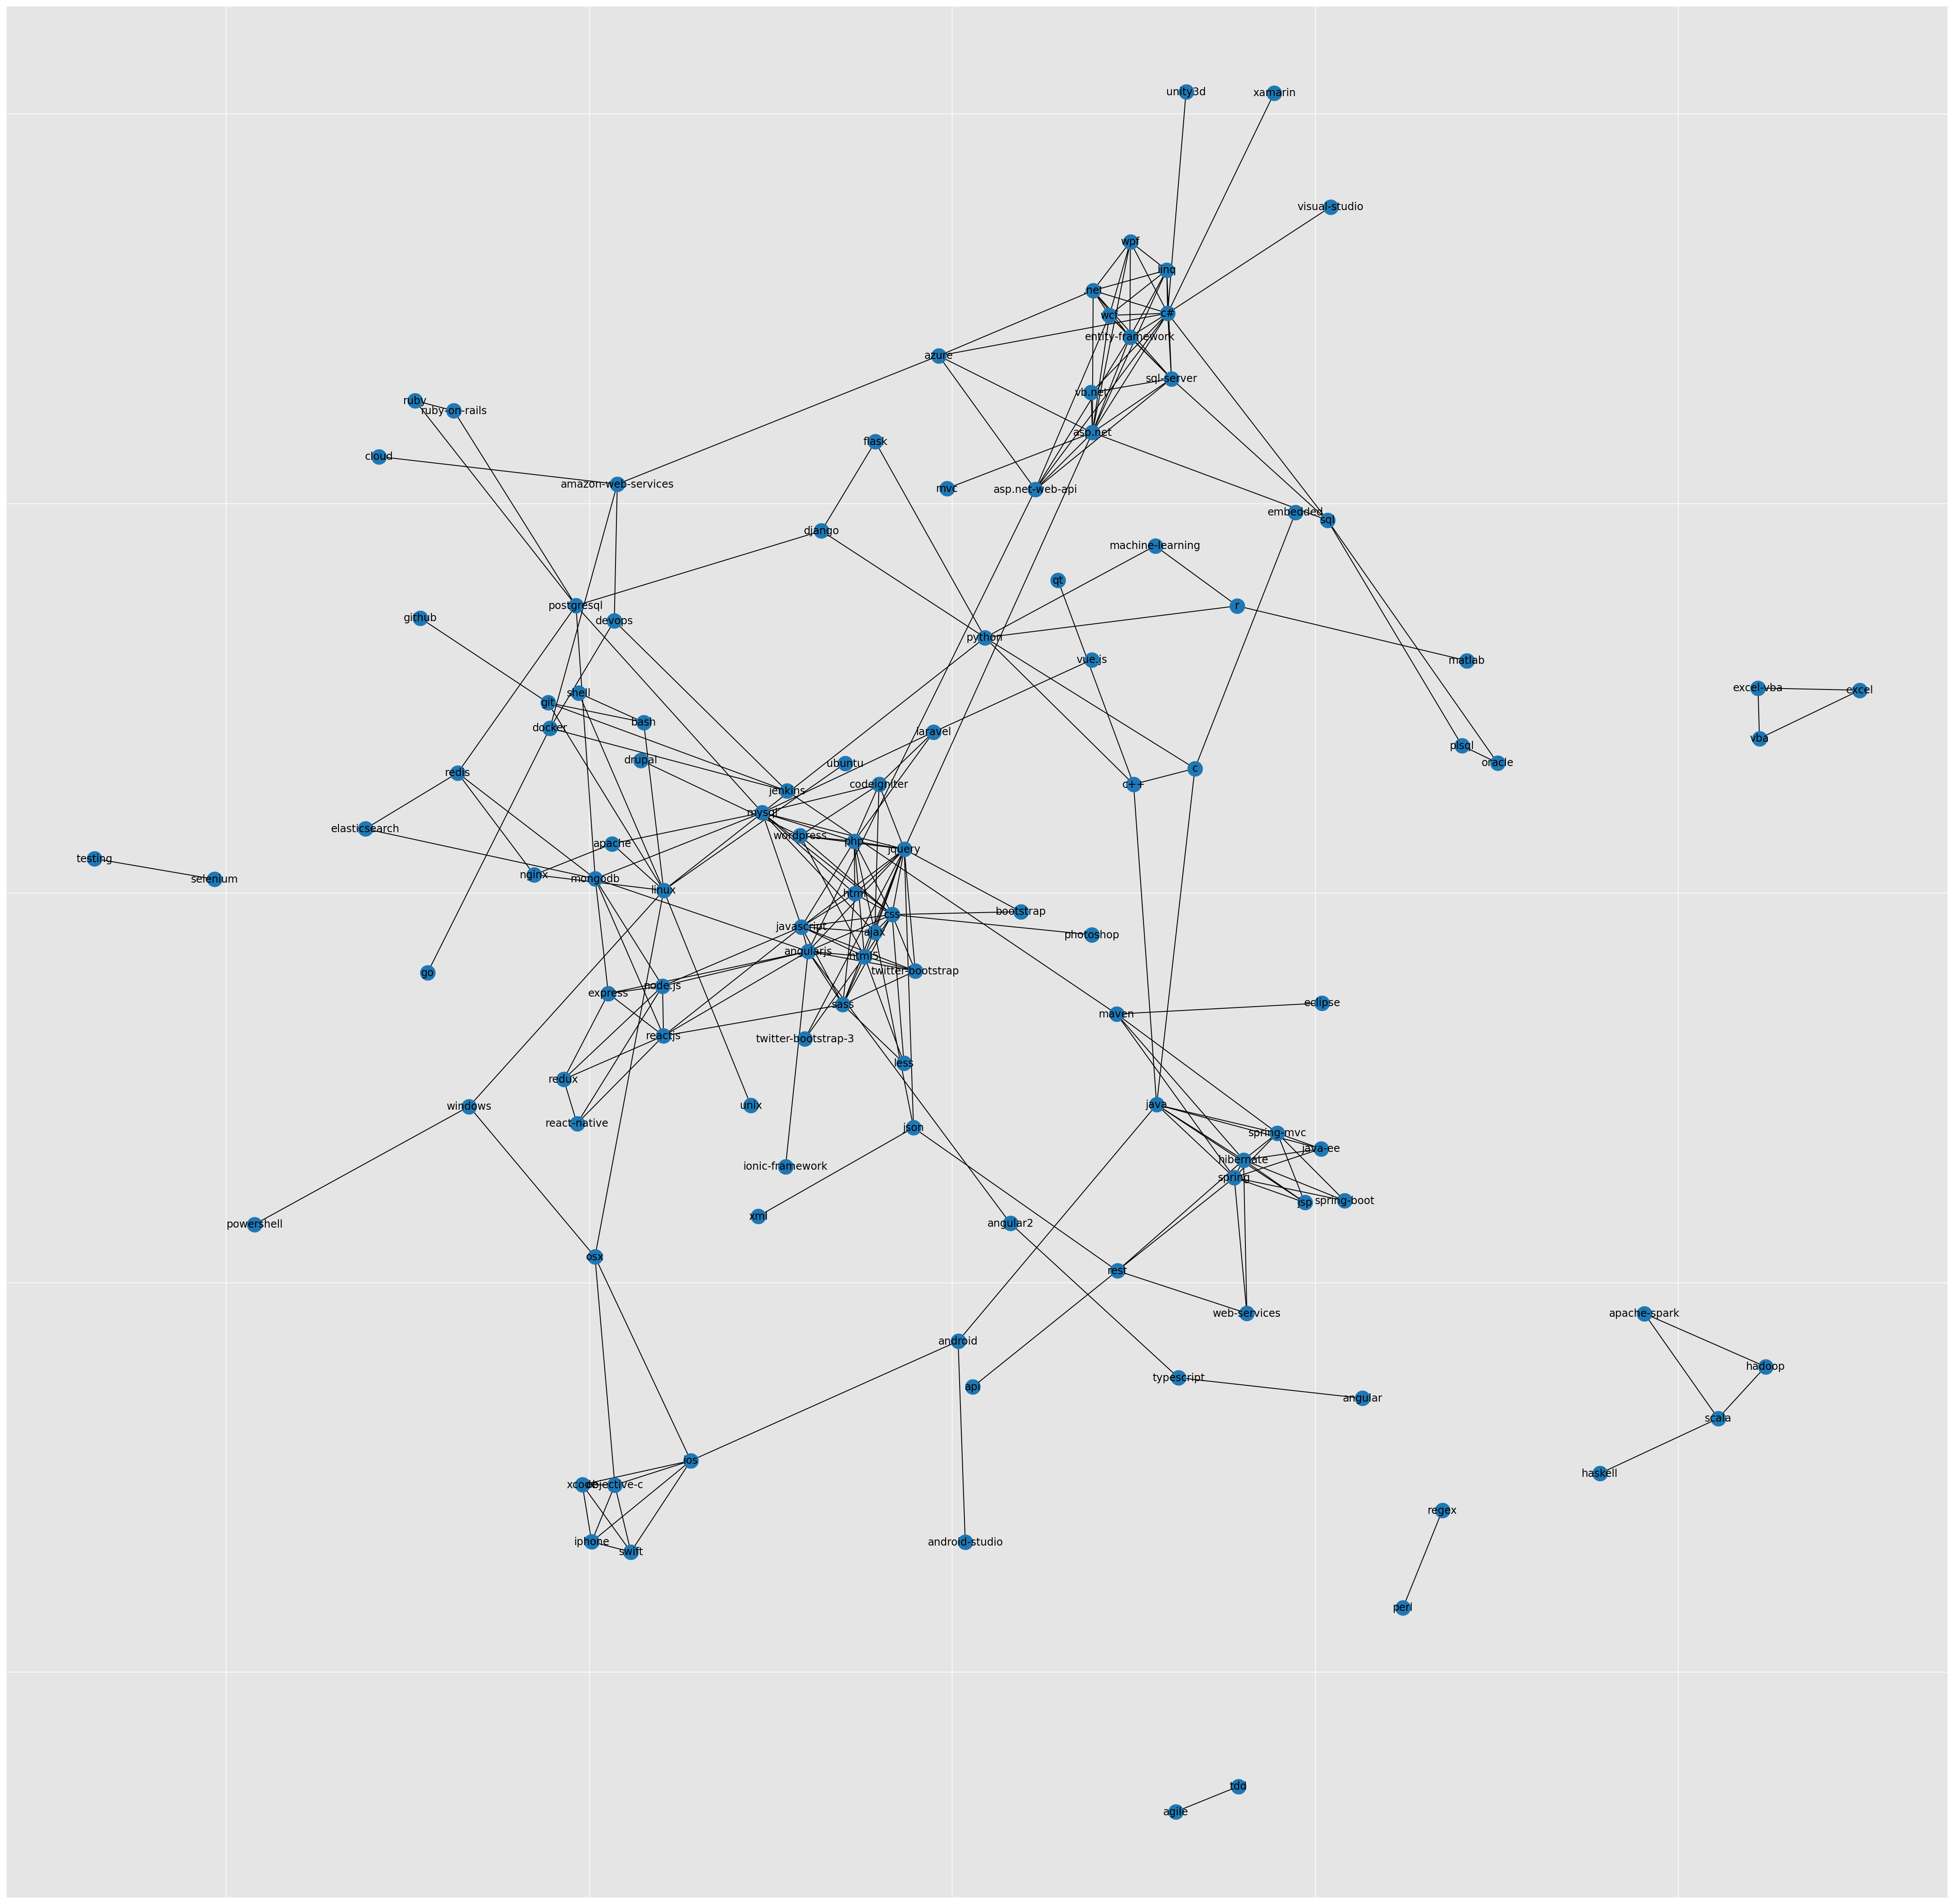

In [253]:
# Basic network (without readily provided data on group & nodesize)
# scale sets base node size
# k sets distance between nodes
# iterations defaults to 50
pos = nx.drawing.spring_layout(G, scale=1.25, k=0.80,iterations=60)

plt.figure(figsize=(40, 40))
nx.draw_networkx(G,pos=pos, edge_color='black')

plt.show()

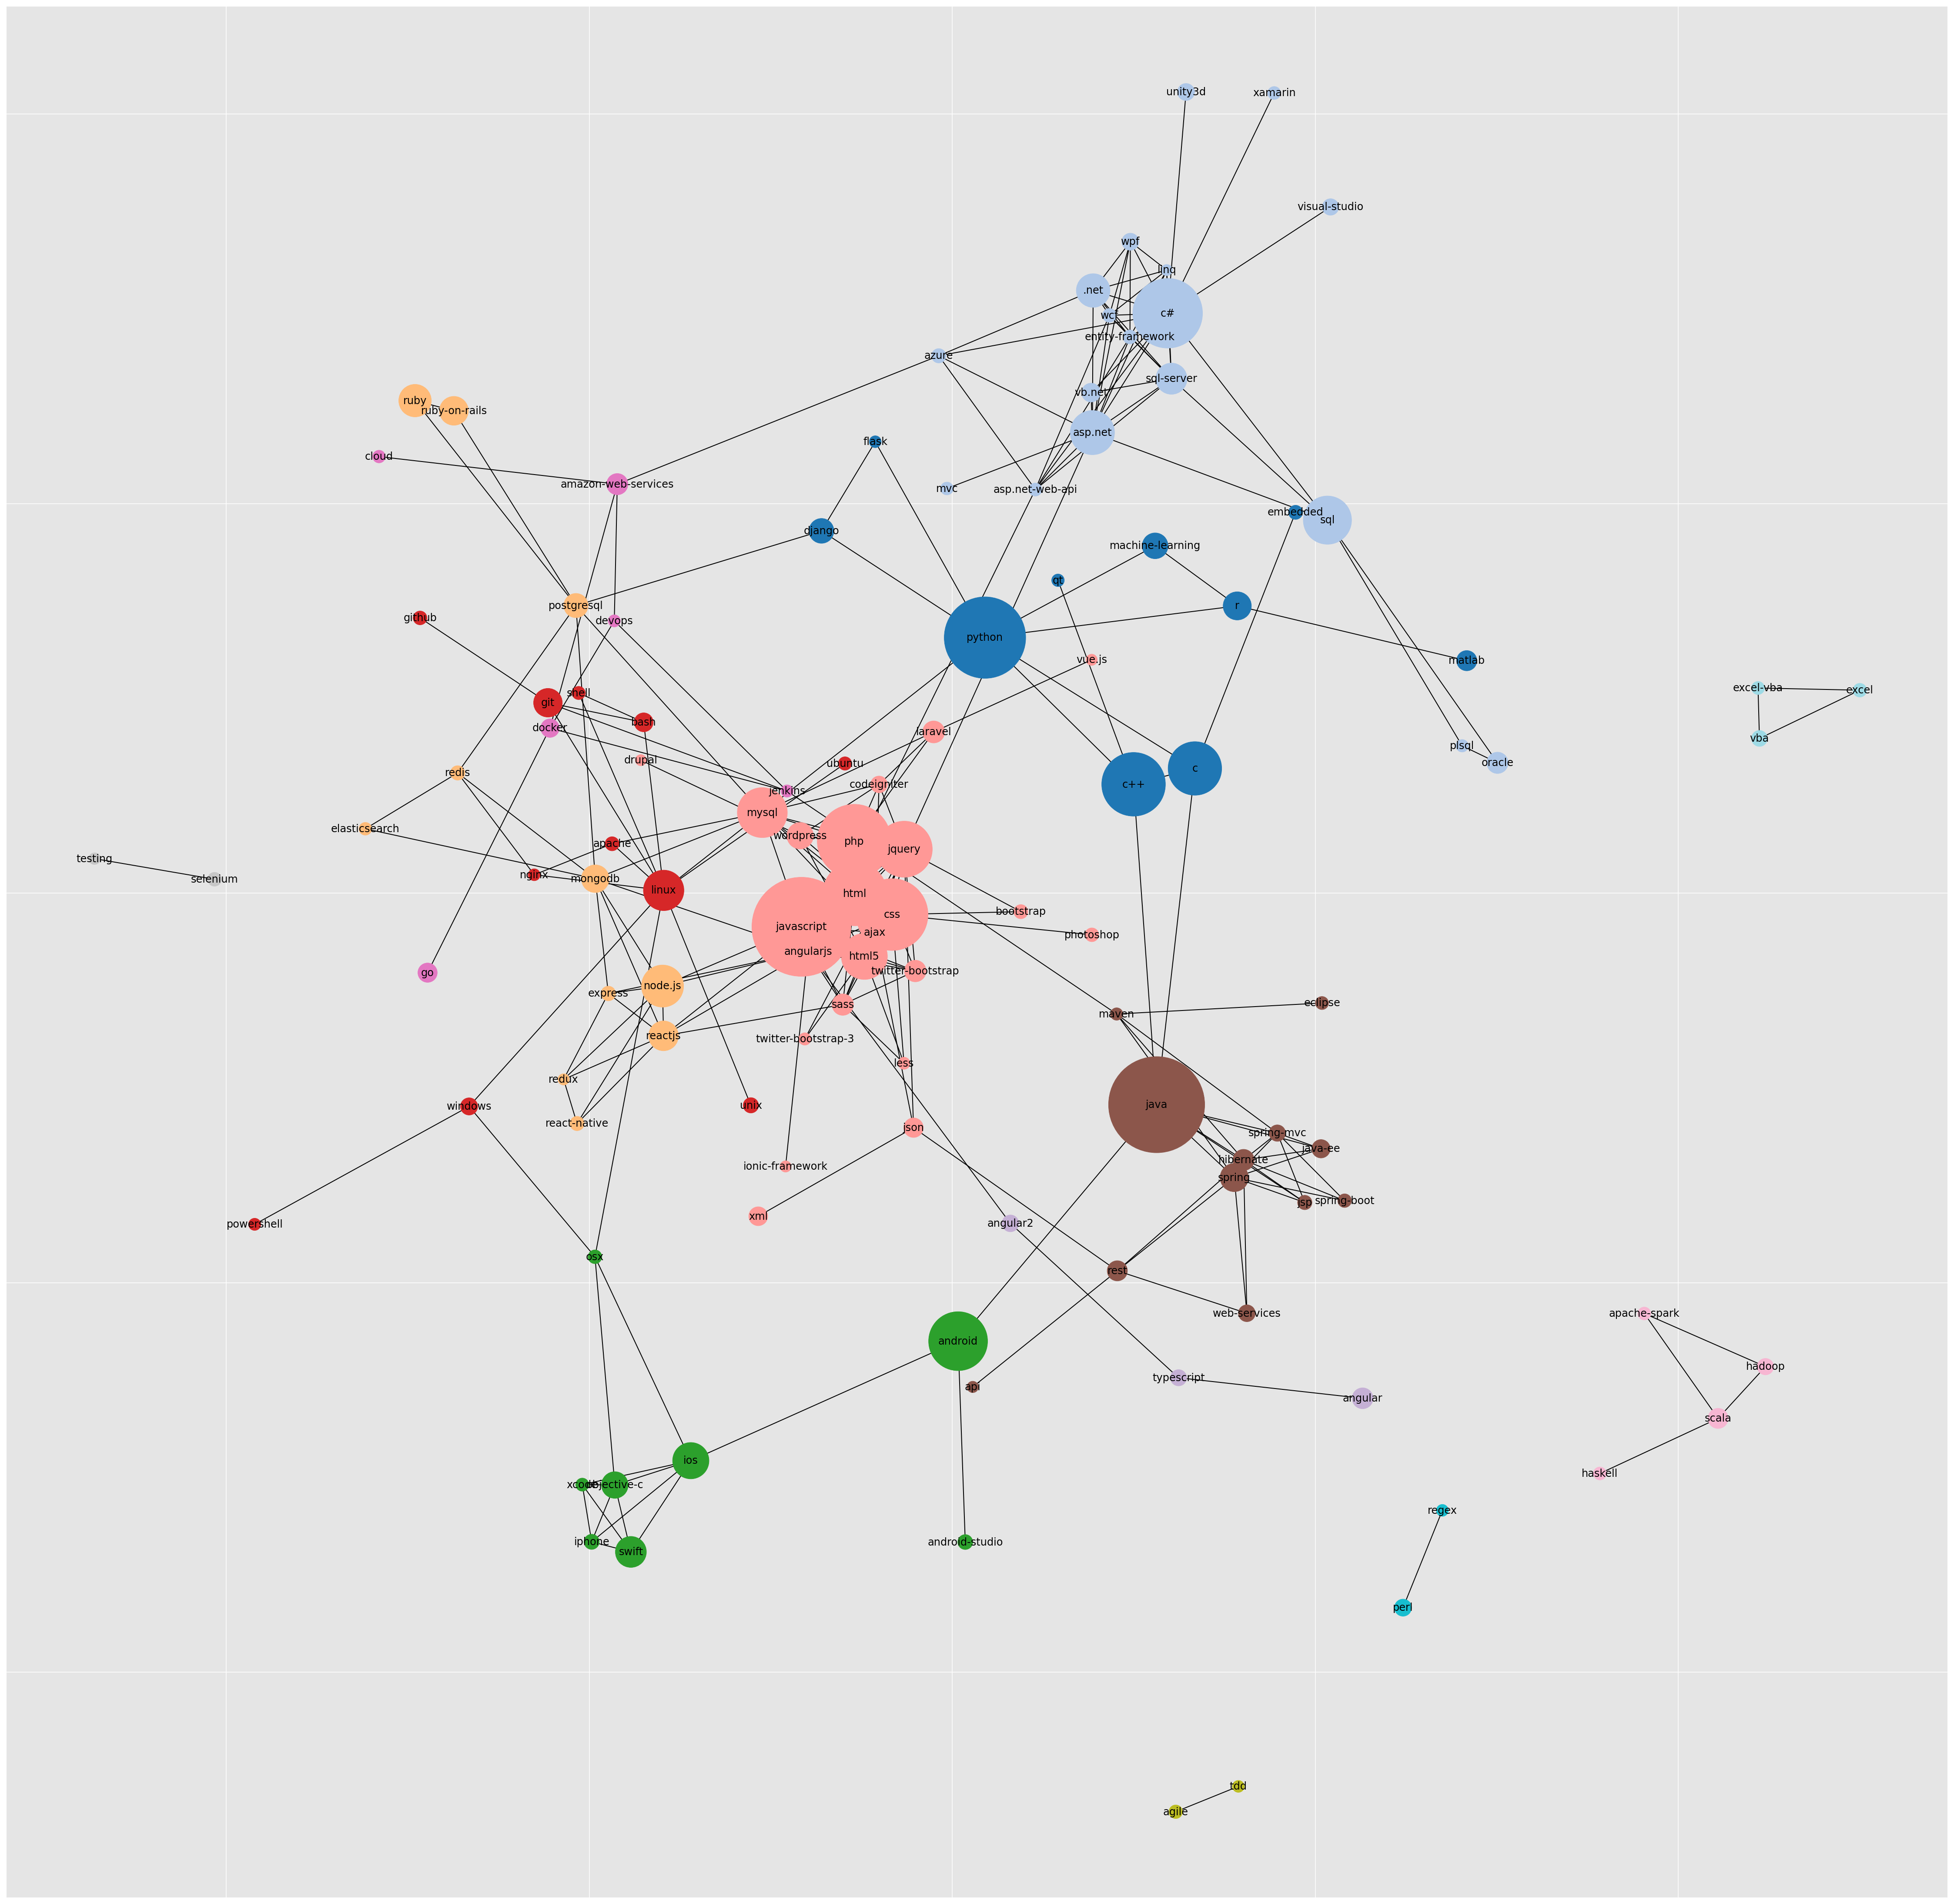

In [254]:
# color code and size nodes accordingly (from provided data)
node_color_lst= [[d['group']] for n,d in G.nodes(data=True)]
node_size = [d['nodesize']*20 for n,d in G.nodes(data=True)]

plt.figure(figsize=(40, 40))
nx.draw_networkx(G,pos=pos,node_color=node_color_lst, cmap=plt.cm.tab20, node_size=node_size, edge_color='black')

plt.show()

### Degree, Group, and Node Size Distribution

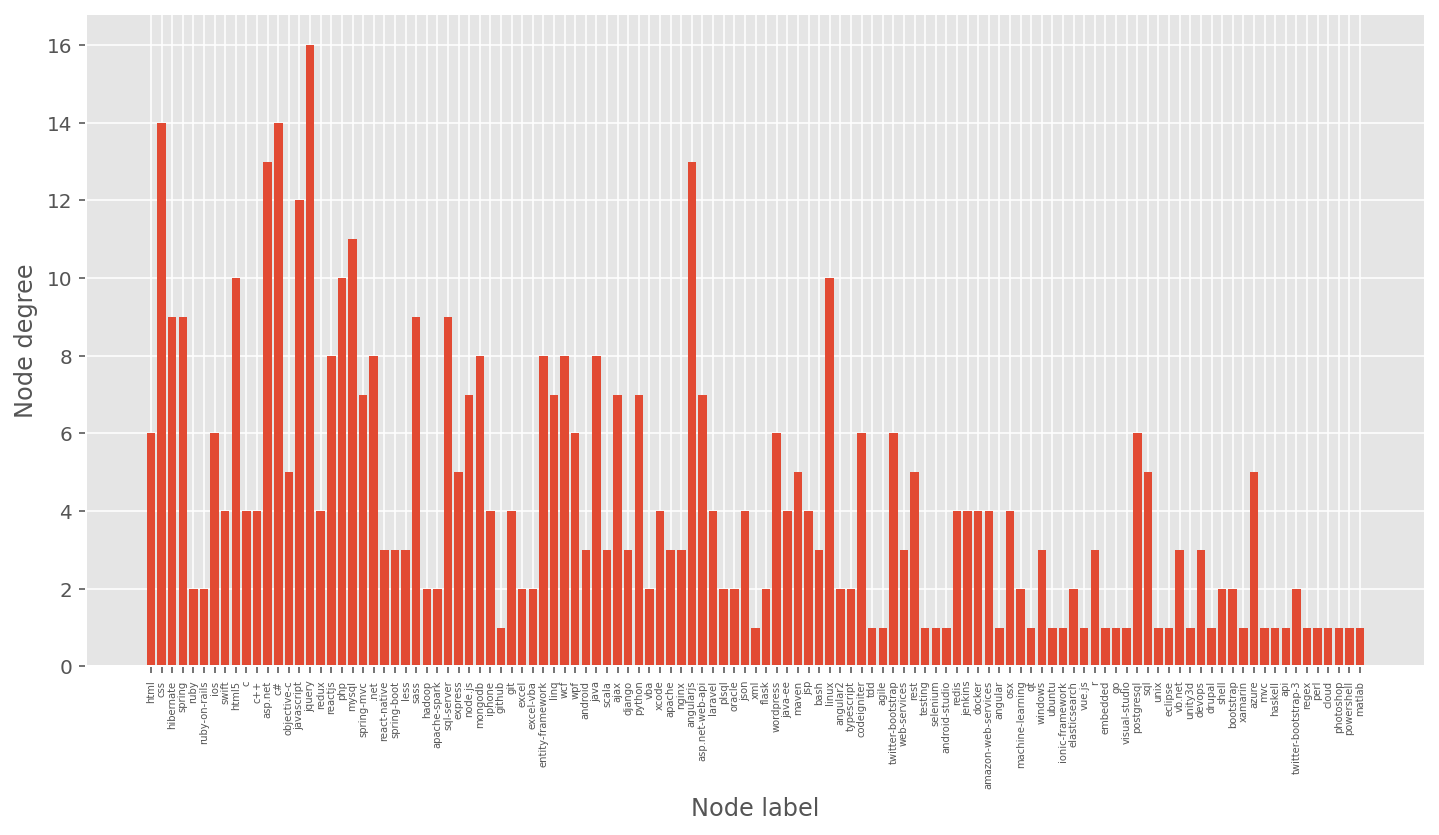

In [268]:
# Node degrees show nodes with most links
dct_G = dict(G.degree())

# Bar plot - use the dict from above as your x & y
plt.figure(figsize=(12, 6))
plt.bar(dct_G.keys(), dct_G.values())
plt.xlabel('Node label')
plt.ylabel('Node degree')
plt.xticks(rotation=90, fontsize=5);

In [342]:
# Top 20 node degrees
degree_df = pd.DataFrame(dct_G.items(), index=list(range(len(dct_G))))
degree_df.columns = ['language', 'degrees']
degree_df.head()

,language,degrees
0,html,6
1,css,14
2,hibernate,9
3,spring,9
4,ruby,2


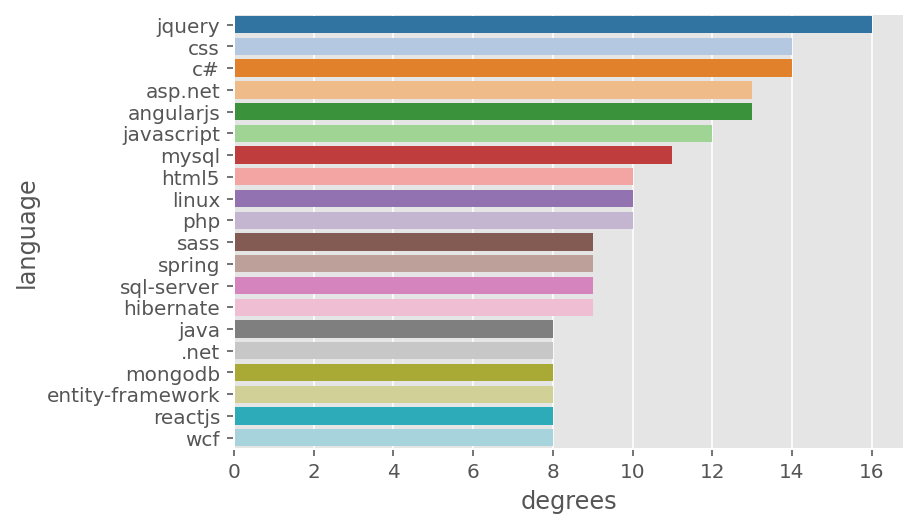

In [341]:
top_20_degrees = degree_df.sort_values(by='degrees', ascending=False).head(20)
sns.barplot(data=top_20_degrees, x='degrees', y='language', orient='h', palette='tab20');

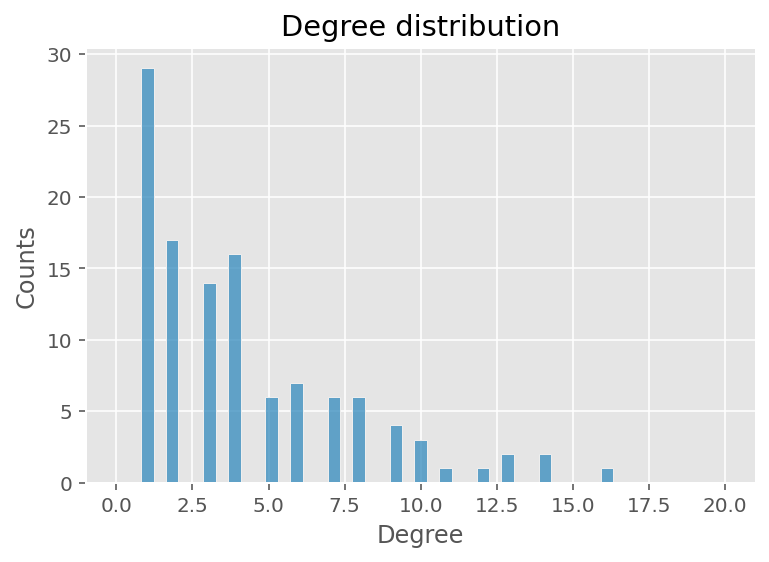

In [320]:
# Degree distribution of nodes 
sns.histplot(list(dct_G.values()), bins=np.linspace(0, 20))
plt.xlabel('Degree')
plt.ylabel('Counts')
plt.title('Degree distribution');

### Charts based on provided data

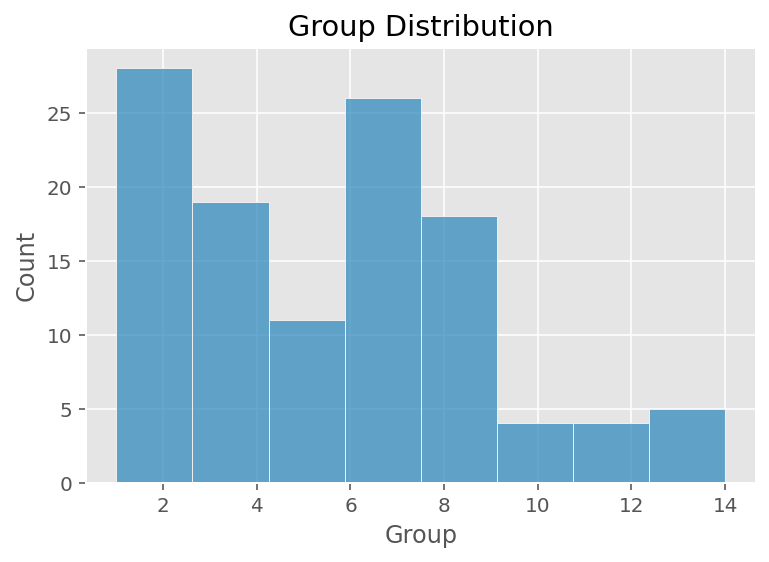

In [311]:
# Compare with group distribution
sns.histplot(data=nodes, x='group')
plt.xlabel('Group')
plt.ylabel('Count')
plt.title("Group Distribution");

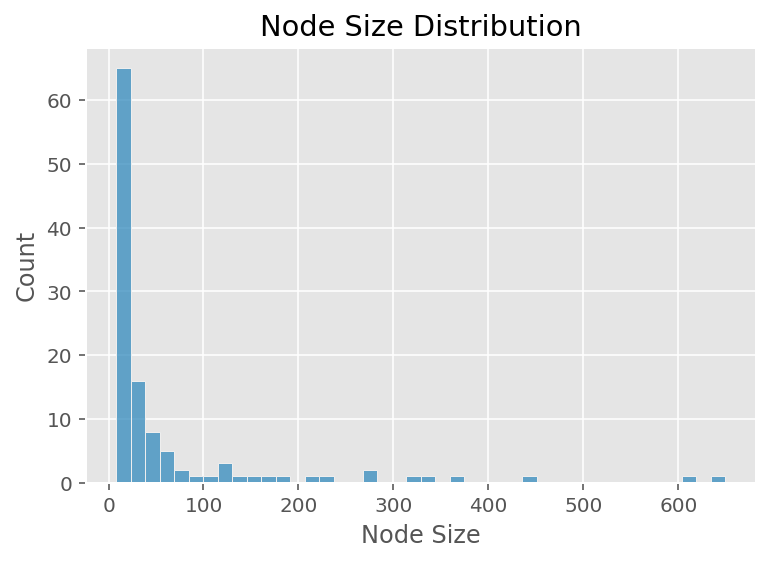

In [310]:
# Node size distribution
sns.histplot(data=nodes, x='nodesize')
plt.xlabel("Node Size")
plt.ylabel("Count")
plt.title("Node Size Distribution");

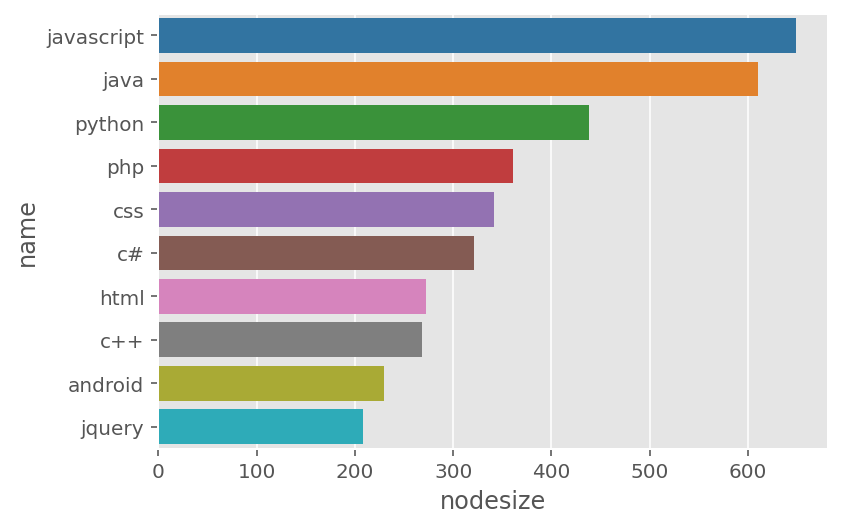

In [308]:
# Top 10 largest nodes
top_10_nodes = nodes.sort_values(by='nodesize', ascending=False).head(10)
sns.barplot(data=top_10_nodes, x='nodesize', y='name', orient='h', palette='tab10');

### Centrality Measures

- For this dataset the betweeness centrality can help identify more important nodes in this network.
- Nodes with a higher betweeness will show us which language/tool is potentially the most versatile.
- Node betweeness can identify important individual nodes.
- Edge betweeness can identify important links between two given nodes.

### Node Betweenness Centrality

In [259]:
# Check for node centrality
node_centrality = nx.betweenness_centrality(G)
#node_centrality

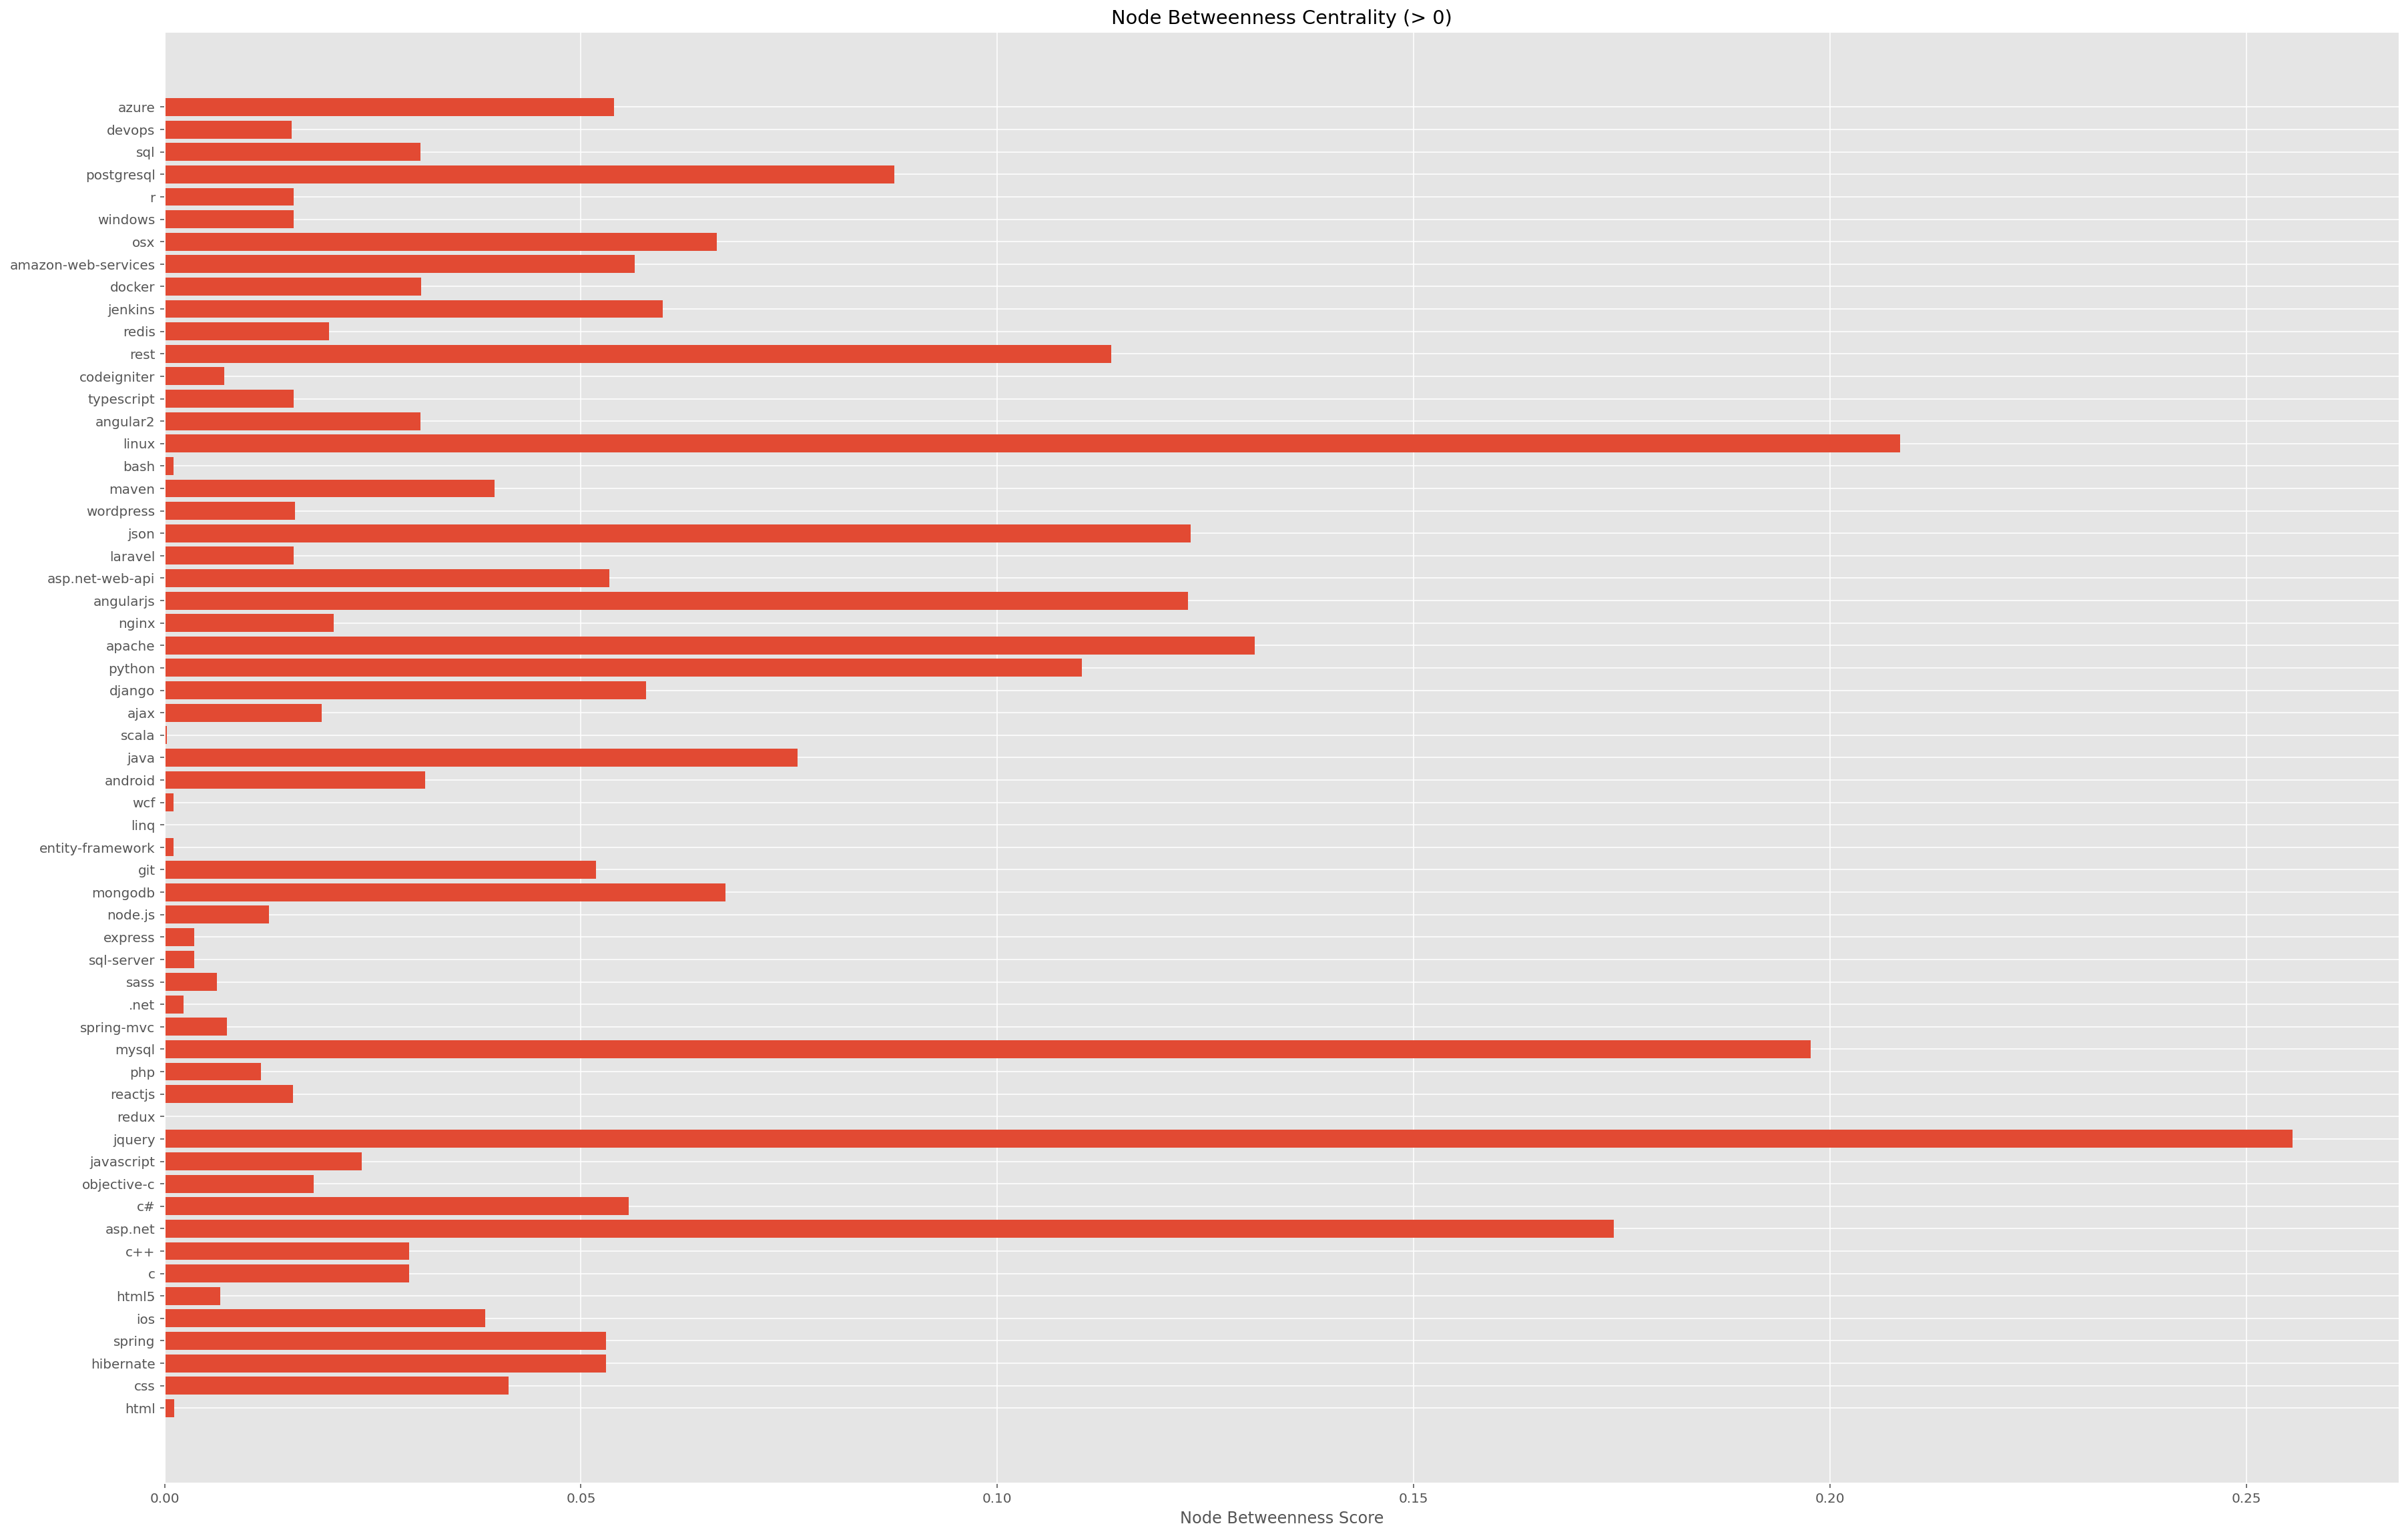

In [260]:
# Filtered graph so nodes with no centrality measure (zero score) ignored
node_centrality_filt = dict()

# Edit node centrality threshold accordingly:
for (key, value) in node_centrality.items():
   if value > 0.0:
       node_centrality_filt[key] = value

plt.figure(figsize=(30, 20))
plt.barh(list(range(len(list(node_centrality_filt.values())))), list(node_centrality_filt.values()))
plt.yticks(list(range(len(node_centrality_filt))), list(node_centrality_filt.keys()))
plt.xlabel("Node Betweenness Score")
plt.title('Node Betweenness Centrality (> 0)');

### Edge Betweeness Centrality

In [261]:
# Check for edge centrality
edge_centrality = nx.edge_betweenness_centrality(G)
#edge_centrality

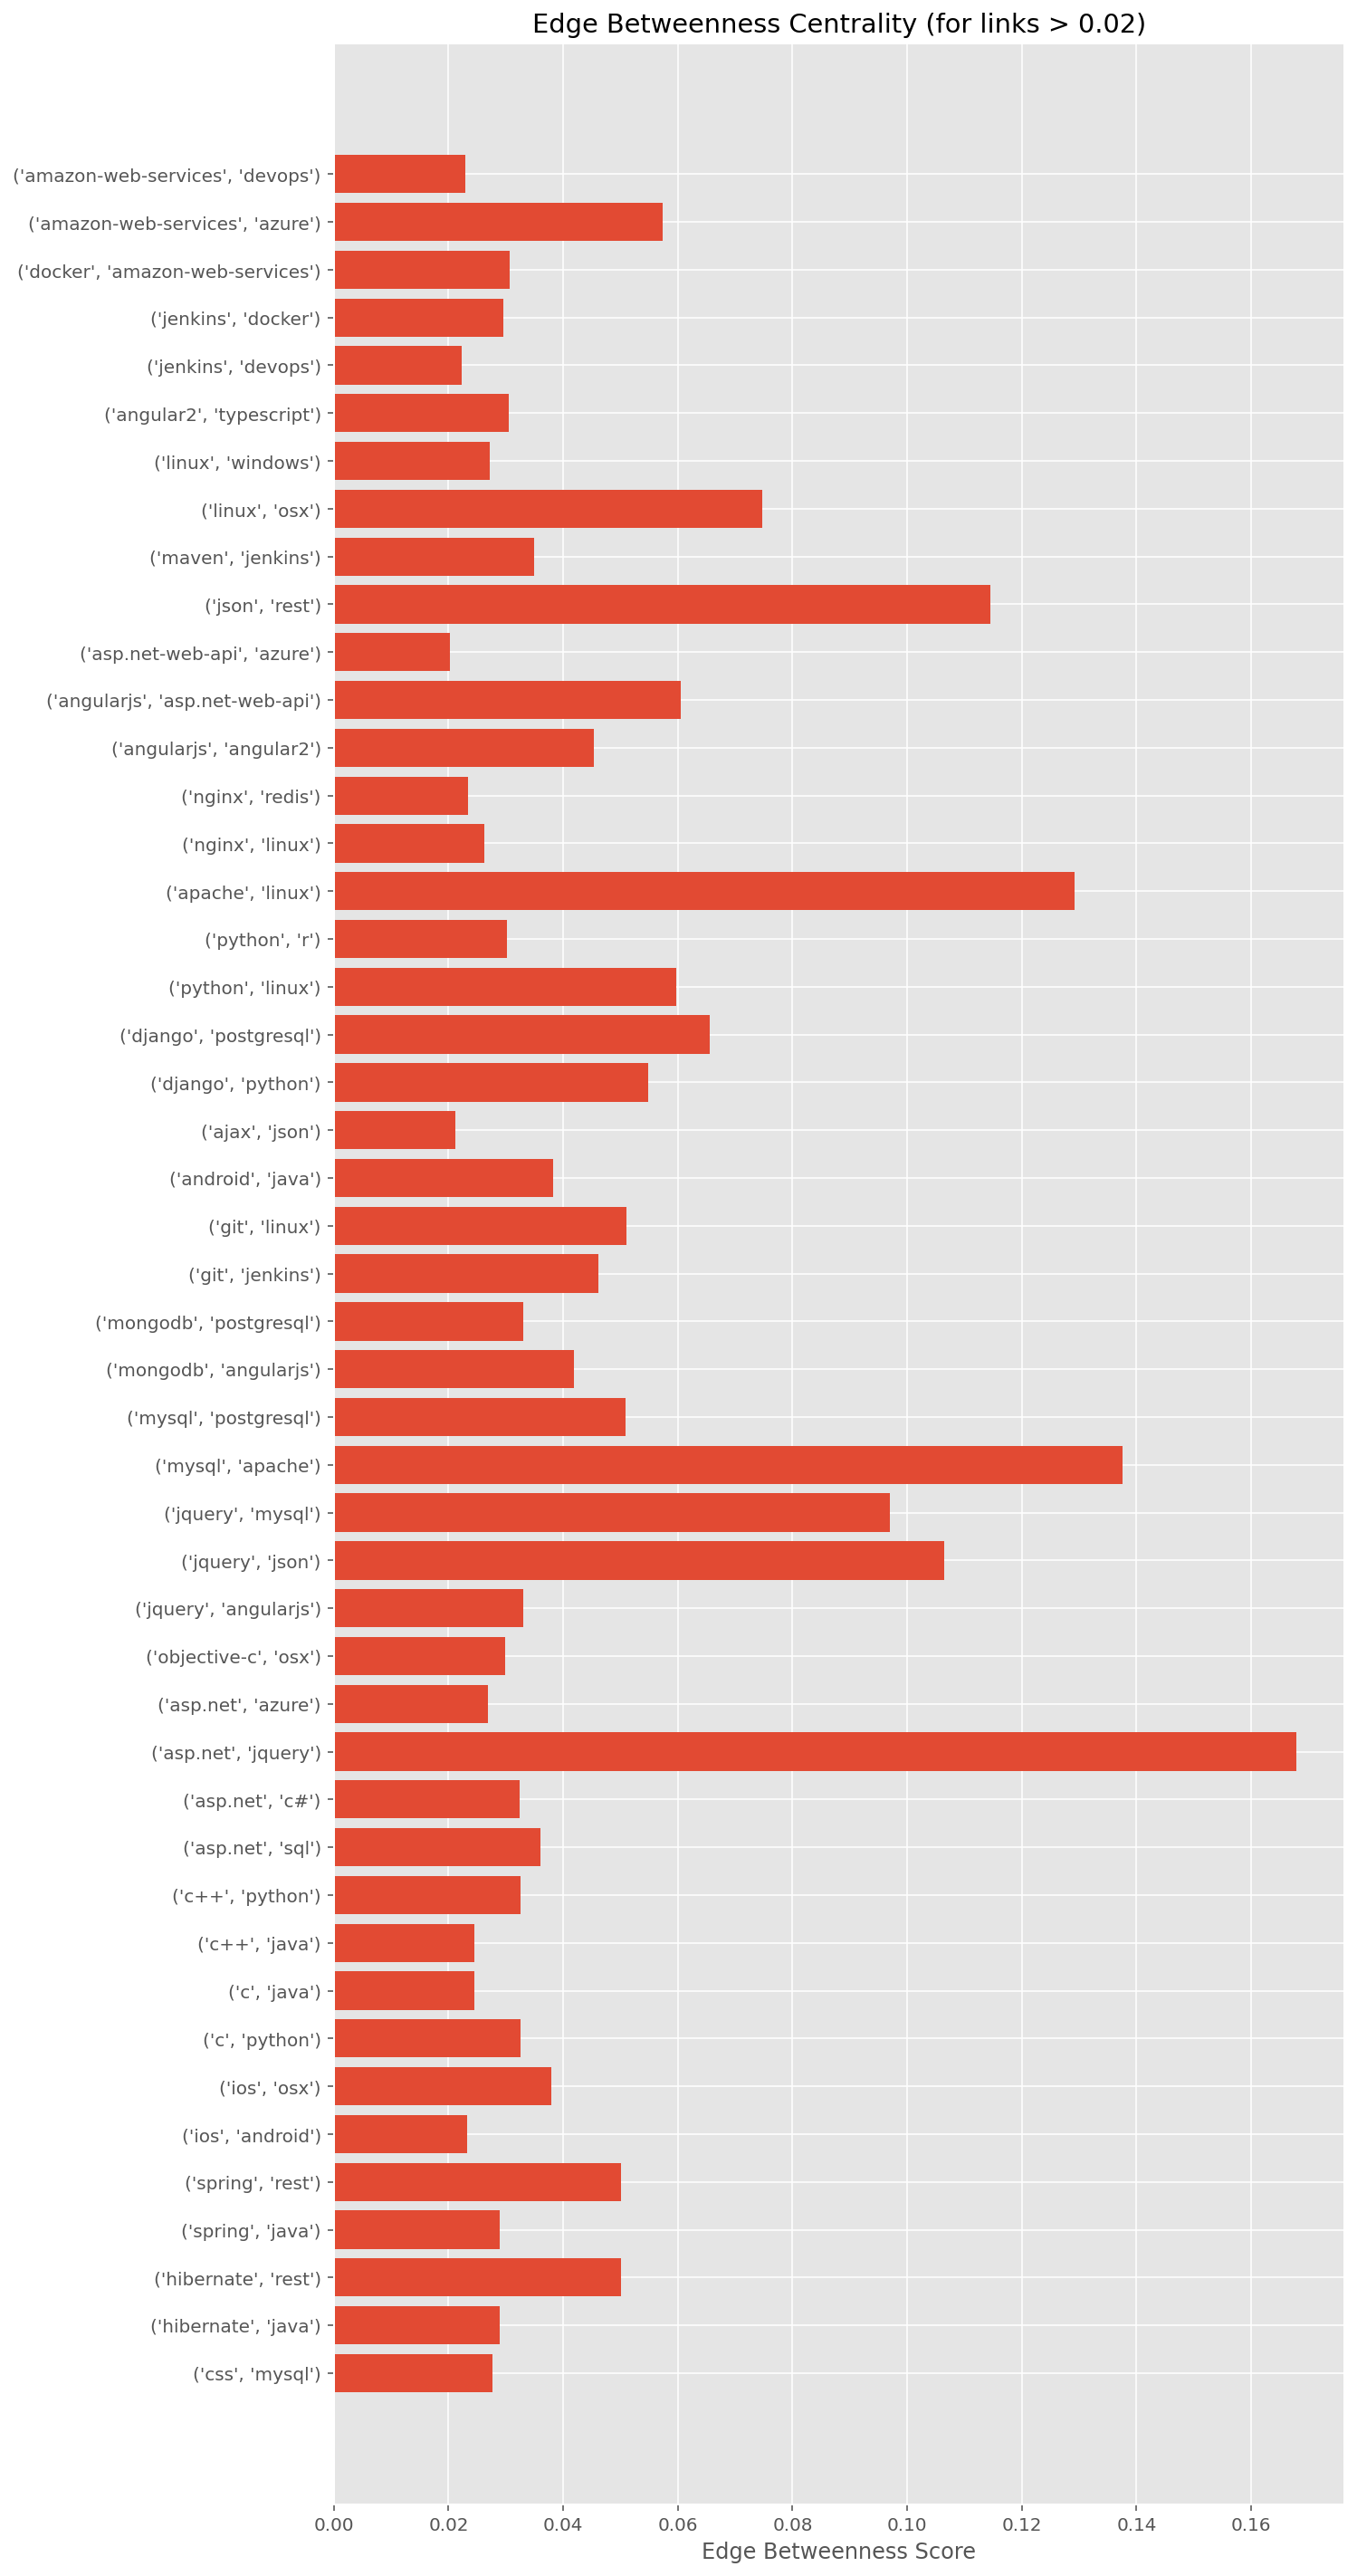

In [263]:
plt.figure(figsize=(10, 25))

edge_centrality_filt = dict()

# Edit edge centrality threshold accordingly:
for (key, value) in edge_centrality.items():
   if value > 0.02:
       edge_centrality_filt[key] = value

plt.barh(list(range(len(list(edge_centrality_filt.values())))),
         list(edge_centrality_filt.values()))
plt.yticks(list(range(len(edge_centrality_filt))), list(edge_centrality_filt.keys()), fontsize=10)
plt.xlabel("Edge Betweenness Score")
plt.title('Edge Betweenness Centrality (for links > 0.02)');